In [2]:
import os
import pandas as pd
import numpy as np
import mdtraj as md
import pickle
from itertools import combinations

# === FrameAnalyzer (your feature setup) ===
class FrameAnalyzer:
    def __init__(self):
        self.res_indx = [20, 48, 82, 89, 207, 215, 244, 247, 248, 251, 255]
        self.res_pair = list(combinations(self.res_indx, 2))

    def analyze_trajectory(self, pdb_file):
        trj = md.load(pdb_file)
        frame = trj[0]

        # 55 CA-CA contact distances
        contact_features = []
        for pair in self.res_pair:
            contact = md.compute_contacts(frame, contacts=[pair], scheme='ca')
            contact_features.append(contact[0][0][0])

        # NPxxY motif angles
        topo = frame.topology
        res = [r for r in topo.residues]
        atm = [a for a in topo.atoms]
        res_npxxy = []

        for i in range(len(res)):
            if str(res[i])[:3] == 'ASN' and str(res[i+1])[:3] == 'PRO' and str(res[i+4])[:3] == 'TYR':
                res_npxxy.append((str(res[i])[3:], str(res[i+1])[3:], str(res[i+4])[3:]))
                break

        asn_atoms = {a.name: a.index for a in atm if 'ASN' + res_npxxy[0][0] in str(a)}
        pro_atoms = {a.name: a.index for a in atm if 'PRO' + res_npxxy[0][1] in str(a)}
        tyr_atoms = {a.name: a.index for a in atm if 'TYR' + res_npxxy[0][2] in str(a)}

        angles = []
        for atom_group in [asn_atoms, pro_atoms, tyr_atoms]:
            inds = [atom_group['O'], atom_group['C'], atom_group['N']]
            angle = md.compute_angles(frame, [inds], periodic=True)[0][0]
            angles.append(angle)

        return np.array([*angles, *contact_features]).reshape(1, -1)

# === Absolute activity predictor ===
class AbsoluteActivityCalculator:
    def __init__(self, model_path):
        with open(model_path, 'rb') as f:
            self.model = pickle.load(f)
        self.analyzer = FrameAnalyzer()

    def predict_activity(self, pdb_path):
        features = self.analyzer.analyze_trajectory(pdb_path)
        return self.model.predict(features)[0]

# === Paths ===
reference_pdb = "../b2_active_crystal_reference.pdb"
pdb_folder = "../minimized_inactive"
angle_csv = "../data/delta_angles_from_reference.csv"
model_path = "../model/xgb_activity_regressor.pkl"
output_csv = "../results/deltaA_by_deltaTheta_test.csv"

# === Load angle CSV and model ===
df = pd.read_csv(angle_csv)
predictor = AbsoluteActivityCalculator(model_path)
activity_ref = predictor.predict_activity(reference_pdb)
print(f"Predicted activity of reference (β2AR): {activity_ref:.4f}")

results = []

# === Loop through samples ===
for i, row in df.iterrows():
    original_sampled_file = row["sampled_file"]
    sampled_file = "equil_replaced_" + original_sampled_file  
    delta_theta = row["delta_angle_rad"]

    sampled_path = None
    for residue_dir in os.listdir(pdb_folder):
        test_path = os.path.join(pdb_folder, residue_dir, sampled_file)
        if os.path.exists(test_path):
            sampled_path = test_path
            break

    if not sampled_path:
        print(f"File not found: {sampled_file}")
        continue

    try:
        activity_sample = predictor.predict_activity(sampled_path)
        delta_a = activity_ref - activity_sample
        delta_by_theta = delta_a / delta_theta if abs(delta_theta) > 1e-6 else np.nan

        results.append({
            "residue_index": row["residue_index"],
            "residue_name": row["residue_name"],
            "sampled_file": sampled_file,
            "ref_angle_rad": row["ref_angle_rad"],
            "sampled_angle_rad": row["sampled_angle_rad"],
            "delta_angle_rad": delta_theta,
            "activity_ref": activity_ref,
            "activity_sample": activity_sample,
            "delta_activity": delta_a,
            "deltaA_by_deltaTheta": delta_by_theta
        })

    except Exception as e:
        print(f"⚠️ Error processing {sampled_file}: {e}")

# === Step 1: Clean up and enrich the result DataFrame
df_out = pd.DataFrame(results)
# df_out.to_csv(output_csv, index=False)

# === Step 2: Map residue ID and name from reference PDB
traj = md.load(reference_pdb)
topology = traj.topology
residues = list(topology.residues)

# Python-based residue index to PDB resSeq and name
index_to_resSeq = {i: res.resSeq for i, res in enumerate(residues)}
index_to_resname = {i: res.name for i, res in enumerate(residues)}

df_out["pdb_residue_id"] = df_out["residue_index"].map(index_to_resSeq)
df_out["residue_name"] = df_out["residue_index"].map(index_to_resname)

# === Step 3: Summarize per residue 
summary = (
    df_out.groupby(["residue_index", "pdb_residue_id", "residue_name"])
    .agg(
        mean_sensitivity=("deltaA_by_deltaTheta", lambda x: np.mean(np.abs(x))),
        n_samples=("deltaA_by_deltaTheta", "count"),
    )
    .reset_index()
    .sort_values(by="mean_sensitivity", ascending=False)
)


summary = summary[["residue_index", "pdb_residue_id", "residue_name", "mean_sensitivity", "n_samples"]]
summary.columns = ["Index", "PDB_ID", "Residue", "|ΔA/Δθ|", "Samples"]
summary




Predicted activity of reference (β2AR): 86.0245


,Index,PDB_ID,Residue,|ΔA/Δθ|,Samples
47,228,299,GLN,1693.086246,10
5,36,67,VAL,617.609522,10
12,109,140,LYS,430.162314,10
22,125,156,MET,388.228183,10
36,193,224,GLN,276.815395,10
3,22,53,LEU,212.806962,10
37,196,267,LYS,195.468584,10
51,251,322,ASN,174.751319,10
8,53,84,LEU,165.085697,10
14,112,143,SER,138.519540,10


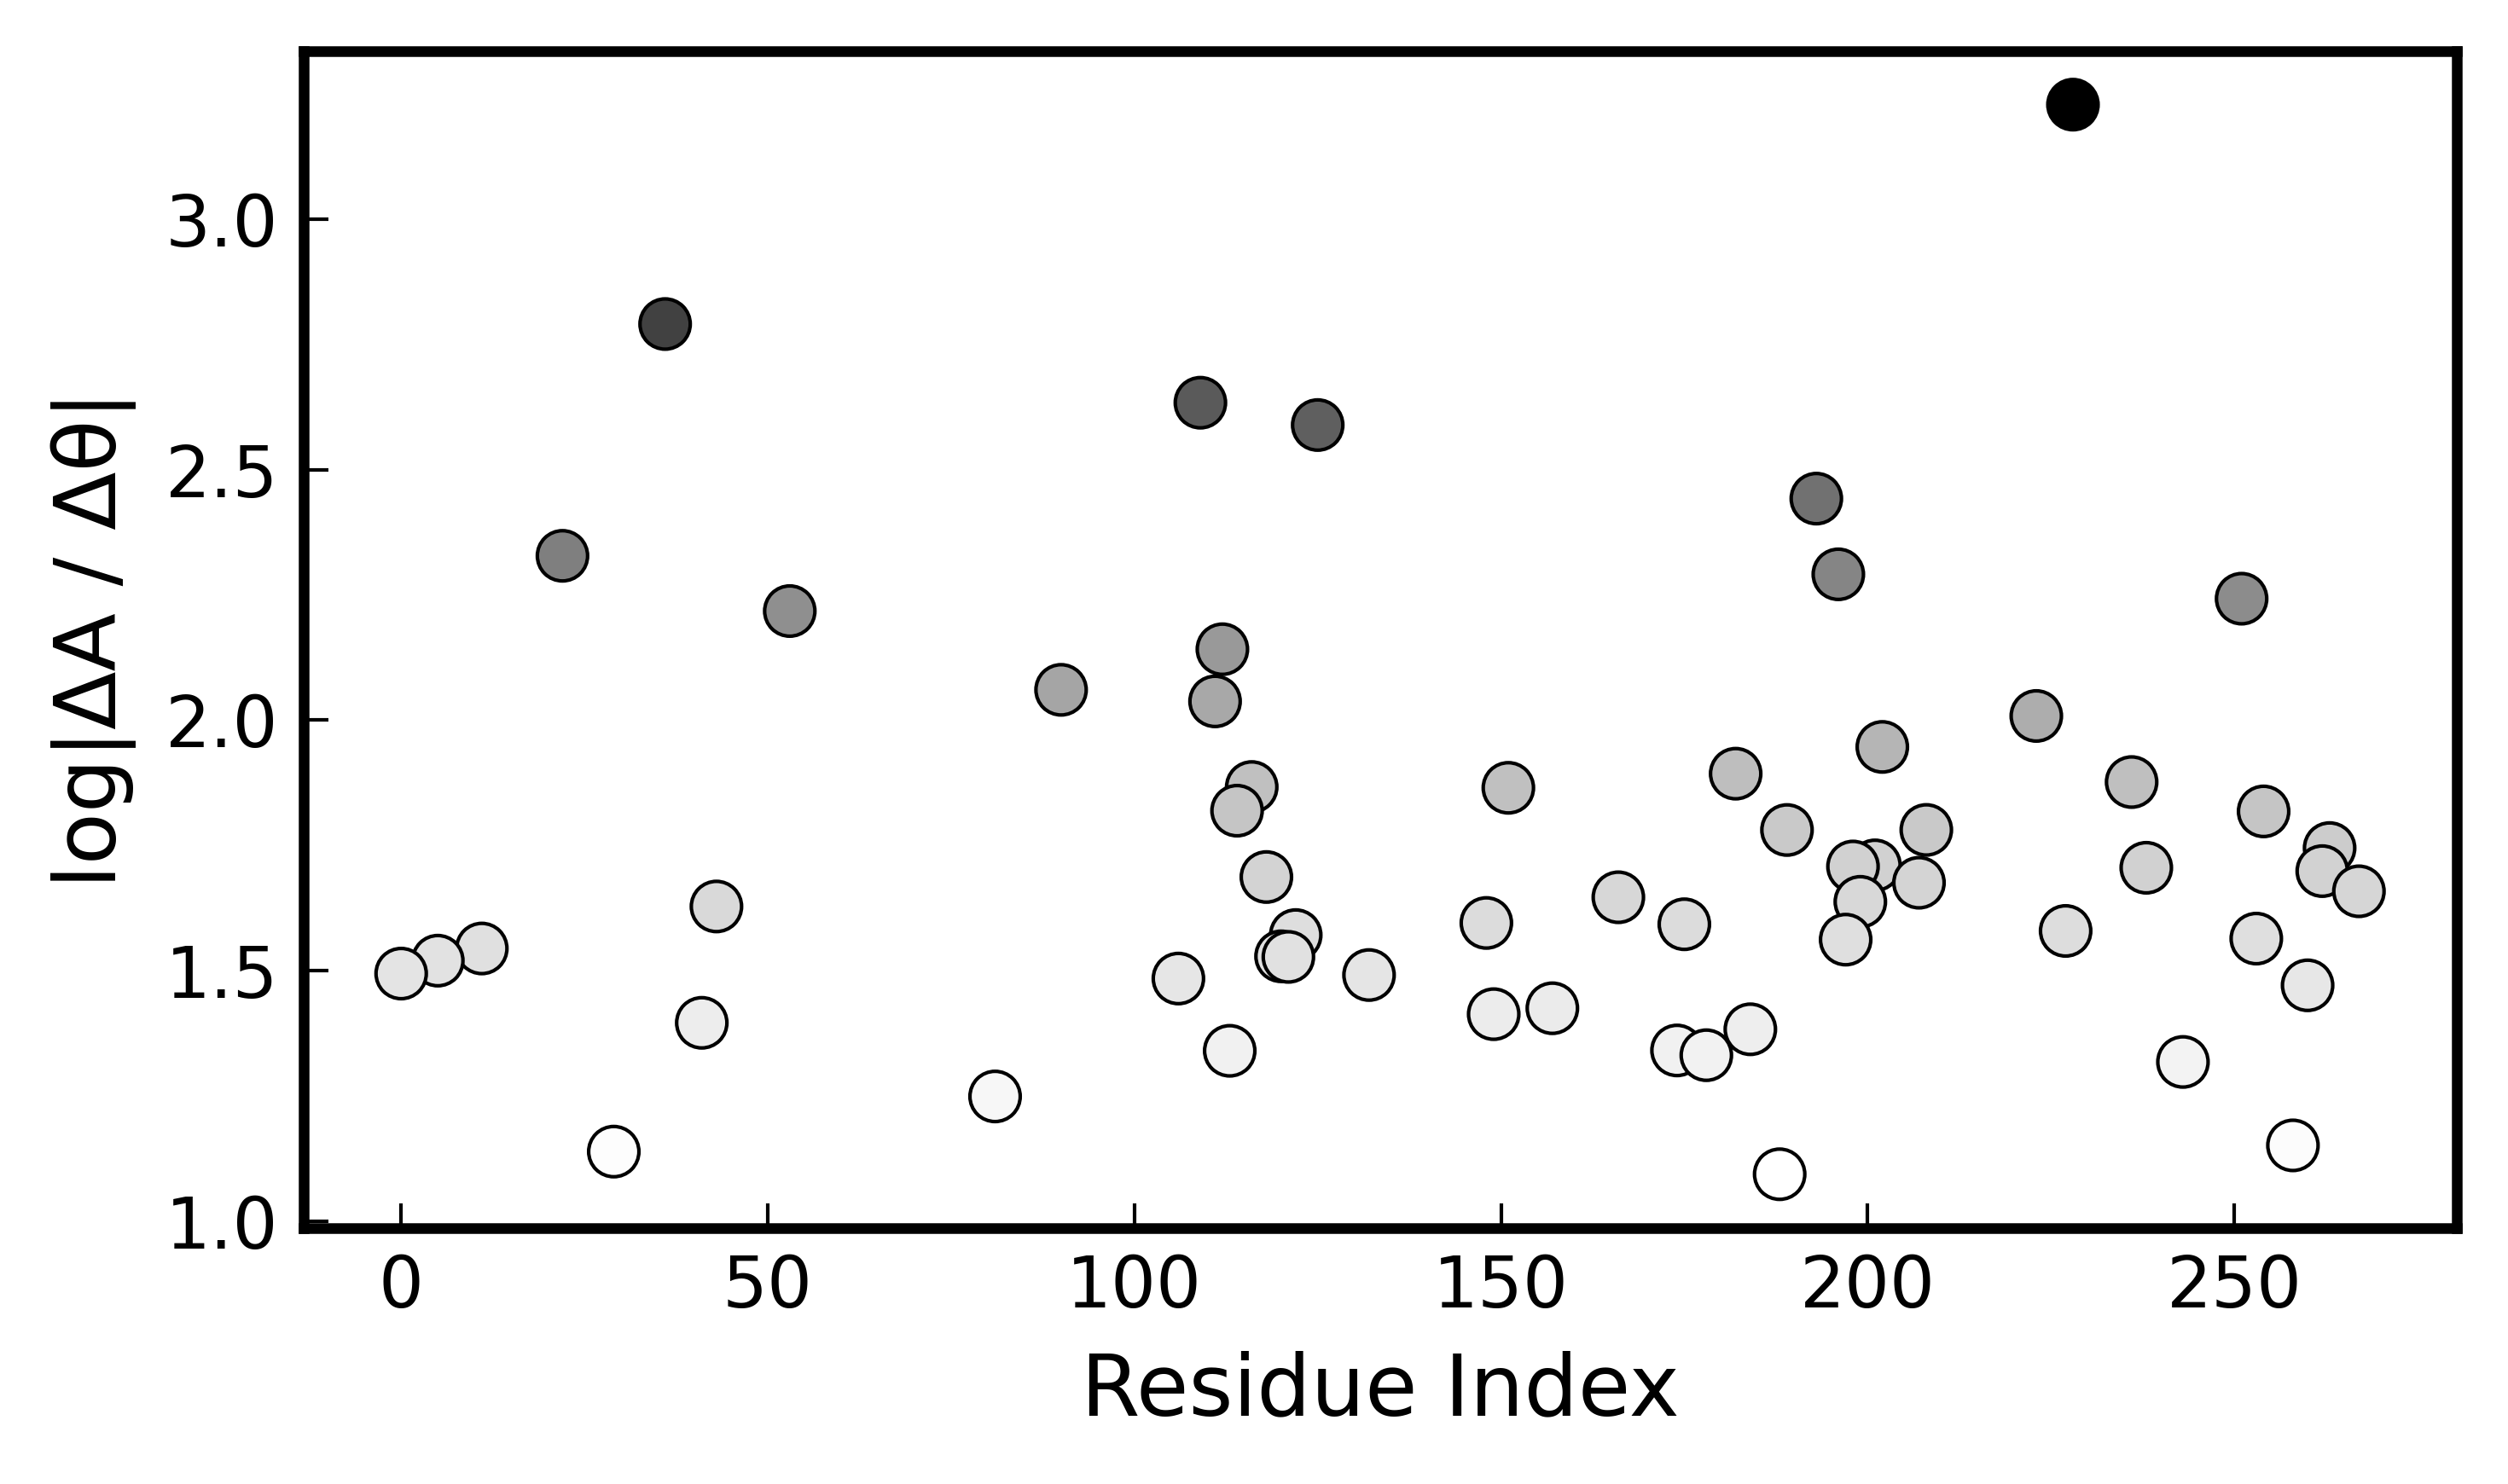

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values
res_ids = summary['Index']
delta_vals = np.log10(summary['|ΔA/Δθ|'])


fig, ax1 = plt.subplots(figsize=(5, 3), dpi=600)


sc = ax1.scatter(
    res_ids, delta_vals,
    c=delta_vals,
    cmap='Greys',
    s=50,
    edgecolors='black',
    linewidth=0.5
)


ax1.set_xlabel("Residue Index", fontsize=12)
ax1.set_ylabel("log|ΔA / Δθ|", fontsize=12)


tick_width = 0.5
plt.tick_params(direction='in', width=tick_width)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)


for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)

plt.tight_layout()
plt.show()


